# Cinema Hall Ticket Sales Analysis Notebook
This notebook was autogenerated to include all sections from `main.py`, inlined.

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Cinema Hall Ticket Sales Analysis
---------------------------------
Author: Emre Şahinoğlu
Date: 2025-05-19

Description:
    End-to-end pipeline for analyzing cinema ticket sales:
    1. Data loading & cleaning
    2. Feature engineering
    3. Exploratory Data Analysis (EDA)
    4. Statistical hypothesis testing
    5. Predictive modeling & classifier comparison
    6. Customer segmentation (K-Means clustering)
    7. Saving outputs & artifacts

Usage:
    python main.py

Outputs:
    - Cleaned data CSV
    - Model & scaler pickles
    - A suite of .png visuals under /visuals
    - Console summary of findings
"""


'\nCinema Hall Ticket Sales Analysis\n---------------------------------\nAuthor: Emre Şahinoğlu\nDate: 2025-05-19\n\nDescription:\n    End-to-end pipeline for analyzing cinema ticket sales:\n    1. Data loading & cleaning\n    2. Feature engineering\n    3. Exploratory Data Analysis (EDA)\n    4. Statistical hypothesis testing\n    5. Predictive modeling & classifier comparison\n    6. Customer segmentation (K-Means clustering)\n    7. Saving outputs & artifacts\n\nUsage:\n    python main.py\n\nOutputs:\n    - Cleaned data CSV\n    - Model & scaler pickles\n    - A suite of .png visuals under /visuals\n    - Console summary of findings\n'

In [2]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, roc_auc_score,
    roc_curve, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis
)
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import joblib


In [3]:
# Configuration
DATA_PATH     = '../data/cinema_hall_ticket_sales.csv'
CLEANED_PATH  = '../data/cleaned_cinema_data.csv'
ARTIFACT_DIR  = '../visuals'
MODEL_DIR     = '../models'
LOGISTIC_PATH = os.path.join(MODEL_DIR, 'logistic_model.pkl')
KNN_PATH      = os.path.join(MODEL_DIR, 'knn_model.pkl')
NB_PATH       = os.path.join(MODEL_DIR, 'naivebayes_model.pkl')
SVM_PATH      = os.path.join(MODEL_DIR, 'svm_model.pkl')
DT_PATH       = os.path.join(MODEL_DIR, 'decisiontree_model.pkl')
RF_PATH       = os.path.join(MODEL_DIR, 'randomforest_model.pkl')
GB_PATH       = os.path.join(MODEL_DIR, 'gradientboost_model.pkl')
BEST_PATH     = os.path.join(MODEL_DIR, 'best_model.pkl')
SCALER_PATH   = os.path.join(MODEL_DIR, 'scaler_model.pkl')
CLUSTER_SCALER_PATH = os.path.join(MODEL_DIR, 'cluster_scaler.pkl')

os.makedirs(ARTIFACT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(message)s',
    datefmt='%Y-%m-%d %H:%M'
)
logger = logging.getLogger(__name__)


In [4]:
# STEP 1: Data Loading & Cleaning
def load_and_clean(path: str) -> pd.DataFrame:
    logger.info(f"Loading data from {path}")
    df = pd.read_csv(path)
    df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
    df['number_of_person'] = df['number_of_person']        .replace('Alone','1').astype(int)
    df['purchase_again'] = df['purchase_again'].map({'Yes':1,'No':0})
    logger.info("Missing values:\n%s", df.isnull().sum())
    df = df.dropna().reset_index(drop=True)
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
    return df


In [5]:
# STEP 2: Feature Engineering
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df['revenue'] = df['number_of_person'] * df['ticket_price']
    df['price_per_person'] = df['ticket_price'] / df['number_of_person']
    bins = [0,17,35,50,65,120]
    labels = ['<18','18-35','36-50','51-65','65+']
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)
    if 'date' in df.columns:
        df['day_of_week'] = df['date'].dt.day_name()
        df['month']       = df['date'].dt.month_name()
        df['is_weekend']  = df['day_of_week'].isin(['Saturday','Sunday']).astype(int)
    else:
        df['day_of_week'] = df['month'] = ''
        df['is_weekend'] = 0
    return df


In [6]:
# STEP 3: EDA
def run_eda(df: pd.DataFrame):
    sns.set(style='whitegrid')
    # Age distribution
    plt.figure(figsize=(8,5))
    sns.histplot(df['age'], bins=20, kde=True)
    plt.title('Age Distribution')
    plt.savefig(f'{ARTIFACT_DIR}/age_distribution.png'); plt.close()

    # Ticket price by seat type
    plt.figure(figsize=(8,5))
    sns.boxplot(x='seat_type', y='ticket_price', data=df)
    plt.title('Ticket Price by Seat Type')
    plt.savefig(f'{ARTIFACT_DIR}/price_by_seat_type.png'); plt.close()

    # Genre counts
    plt.figure(figsize=(8,5))
    order = df['movie_genre'].value_counts().index
    sns.countplot(x='movie_genre', data=df, order=order)
    plt.xticks(rotation=45)
    plt.title('Ticket Sales by Genre')
    plt.savefig(f'{ARTIFACT_DIR}/genre_counts.png'); plt.close()

    # Revenue by genre
    plt.figure(figsize=(8,5))
    rev = df.groupby('movie_genre')['revenue'].sum().sort_values(ascending=False)
    sns.barplot(x=rev.values, y=rev.index)
    plt.title('Revenue by Genre')
    plt.savefig(f'{ARTIFACT_DIR}/revenue_by_genre.png'); plt.close()

    # Repeat rate by age group
    plt.figure(figsize=(8,5))
    rate = df.groupby('age_group')['purchase_again'].mean()
    rate.plot(kind='bar')
    plt.title('Repeat Purchase Rate by Age Group')
    plt.savefig(f'{ARTIFACT_DIR}/repeat_rate_by_age_group.png'); plt.close()

    # Correlation matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(df.select_dtypes(include=[np.number]).corr(),
                annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.savefig(f'{ARTIFACT_DIR}/correlation_matrix.png'); plt.close()

    # Weekly sales trend
    if 'date' in df.columns:
        plt.figure(figsize=(10,5))
        df.set_index('date').resample('W').size().plot()
        plt.title('Weekly Ticket Sales Trend')
        plt.ylabel('Tickets Sold')
        plt.savefig(f'{ARTIFACT_DIR}/weekly_sales_trend.png'); plt.close()


In [7]:
# STEP 4: Statistical Hypothesis Testing
def run_stat_tests(df: pd.DataFrame):
    logger.info("HYPOTHESIS TESTING RESULTS:")
    # H1
    chi2, p, *_ = stats.chi2_contingency(
        pd.crosstab((df['age']>40).astype(int),
                    df['seat_type']=='Premium')
    )
    logger.info("H1 χ²=%.2f, p=%.4f", chi2, p)

    # H2
    g1 = df[df['age_group']=='18-35']['purchase_again']
    g2 = df[df['age_group']!='18-35']['purchase_again']
    t, p2 = stats.ttest_ind(g1, g2, equal_var=False)
    logger.info("H2 t=%.2f, p=%.4f", t, p2)

    # H3
    groups = [grp['ticket_price'].values for _, grp in df.groupby('movie_genre')]
    f, p3 = stats.f_oneway(*groups)
    logger.info("H3 F=%.2f, p=%.4f", f, p3)


In [8]:
# STEP 5: Predictive Modeling & Comparison
def compare_classifiers(df: pd.DataFrame):
    X = df.drop('purchase_again', axis=1)
    y = df['purchase_again']
    cat_cols = ['seat_type','movie_genre','age_group']
    num_cols = ['age','number_of_person','ticket_price',
                'revenue','price_per_person','is_weekend']
    pre = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
    ])

    # define the core set of classifiers
    models = {
        'LogisticRegression': (LogisticRegression(max_iter=1000), LOGISTIC_PATH),
        'KNN':                (KNeighborsClassifier(),      KNN_PATH),
        'NaiveBayes':         (GaussianNB(),               NB_PATH),
        'SVM':                (SVC(probability=True),      SVM_PATH),
        'DecisionTree':       (DecisionTreeClassifier(),   DT_PATH),
        'RandomForest':       (RandomForestClassifier(n_estimators=100), RF_PATH),
        'GradBoost':          (GradientBoostingClassifier(),         GB_PATH)
    }

    # attempt to add XGBoost, but tolerate *any* failure
    try:
        import xgboost
        from xgboost import XGBClassifier
        models['XGBoost'] = (
            XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            os.path.join(MODEL_DIR, 'xgboost_model.pkl')
        )
    except Exception as e:
        logger.warning("XGBoost unavailable, skipping: %s", e)

    # add a few more from lessons
    models.update({
        'LDA': (LinearDiscriminantAnalysis(),  os.path.join(MODEL_DIR,'lda_model.pkl')),
        'QDA': (QuadraticDiscriminantAnalysis(),os.path.join(MODEL_DIR,'qda_model.pkl')),
        'MLP': (MLPClassifier(max_iter=1000),   os.path.join(MODEL_DIR,'mlp_model.pkl'))
    })

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    results = []
    for name, (clf, path) in models.items():
        pipe = Pipeline([('pre', pre), ('clf', clf)])
        pipe.fit(X_train, y_train)
        proba = pipe.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, proba)
        joblib.dump(pipe, path)              # save each trained pipeline
        results.append((name, auc))

    # save numeric scaler separately
    joblib.dump(pre.named_transformers_['num'], SCALER_PATH)

    # pick & save best
    results.sort(key=lambda x: x[1], reverse=True)
    best_name, best_auc = results[0]
    best_pipe = joblib.load(models[best_name][1])
    joblib.dump(best_pipe, BEST_PATH)

    # plot the ROC-AUC comparison
    names, aucs = zip(*results)
    plt.figure(figsize=(10,6))
    sns.barplot(x=list(aucs), y=list(names), palette='magma')
    plt.title('Classifier ROC AUC Comparison')
    plt.xlabel('AUC')
    plt.savefig(f'{ARTIFACT_DIR}/classifier_comparison.png')
    plt.close()

    logger.info("Best model: %s (AUC=%.3f)", best_name, best_auc)



In [9]:
# STEP 6: Customer Segmentation (K-Means)
def customer_segmentation(df: pd.DataFrame, max_k=10):
    feats = df[['age','ticket_price','number_of_person','revenue']]
    scaler = StandardScaler()
    Xs = scaler.fit_transform(feats)

    inertias, sils, ks = [], [], list(range(2, max_k+1))
    for k in ks:
        km = KMeans(n_clusters=k, random_state=42).fit(Xs)
        inertias.append(km.inertia_)
        sils.append(silhouette_score(Xs, km.labels_))

    plt.figure(figsize=(6,4))
    plt.plot(ks, inertias, 'o-'); plt.title('Elbow Method')
    plt.savefig(f'{ARTIFACT_DIR}/elbow.png'); plt.close()

    plt.figure(figsize=(6,4))
    plt.plot(ks, sils, 'o-'); plt.title('Silhouette Scores')
    plt.savefig(f'{ARTIFACT_DIR}/silhouette.png'); plt.close()

    best_k = ks[np.argmax(sils)]
    df['cluster'] = KMeans(n_clusters=best_k, random_state=42).fit_predict(Xs)
    joblib.dump(scaler, CLUSTER_SCALER_PATH)
    logger.info("Customer clusters: %d", best_k)


In [10]:
# Execute full pipeline
df = load_and_clean(DATA_PATH)
df = engineer_features(df)
df.to_csv(CLEANED_PATH, index=False)
run_eda(df)
run_stat_tests(df)
compare_classifiers(df)
customer_segmentation(df)
print("✅ Pipeline complete; artifacts under /models and /visuals.")

2025-05-28 18:54 INFO Loading data from ../data/cinema_hall_ticket_sales.csv
2025-05-28 18:54 INFO Missing values:
ticket_id           0
age                 0
ticket_price        0
movie_genre         0
seat_type           0
number_of_person    0
purchase_again      0
dtype: int64
/var/folders/d9/3g7dtx1d5c76jjh6sb79zbf40000gn/T/ipykernel_49707/470201883.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.groupby('age_group')['purchase_again'].mean()
2025-05-28 18:54 INFO HYPOTHESIS TESTING RESULTS:
2025-05-28 18:54 INFO H1 χ²=0.94, p=0.3314
2025-05-28 18:54 INFO H2 t=-0.80, p=0.4218
2025-05-28 18:54 INFO H3 F=1.83, p=0.1209
2025-05-28 18:54 WARNING XGBoost unavailable, skipping: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed


✅ Pipeline complete; artifacts under /models and /visuals.


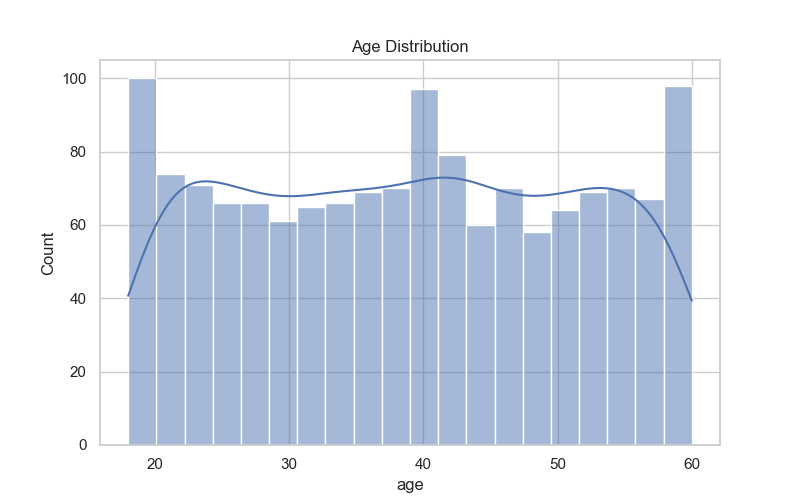

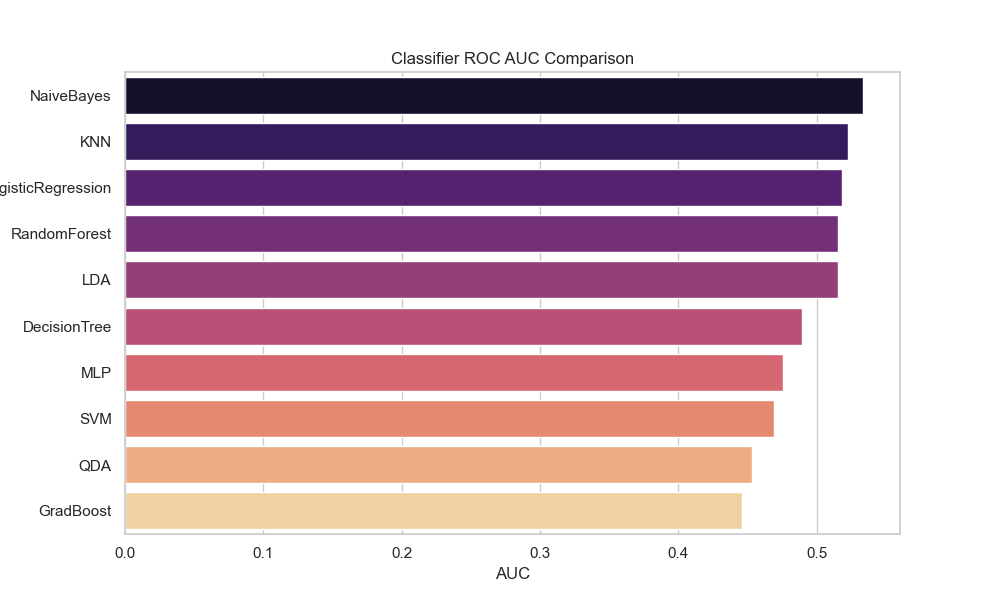

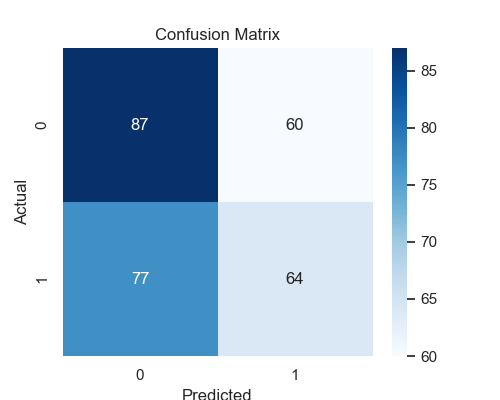

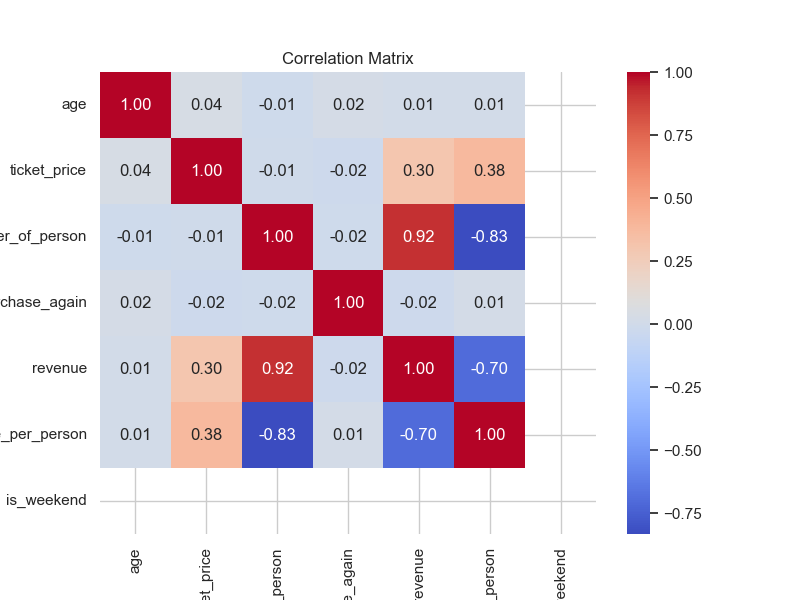

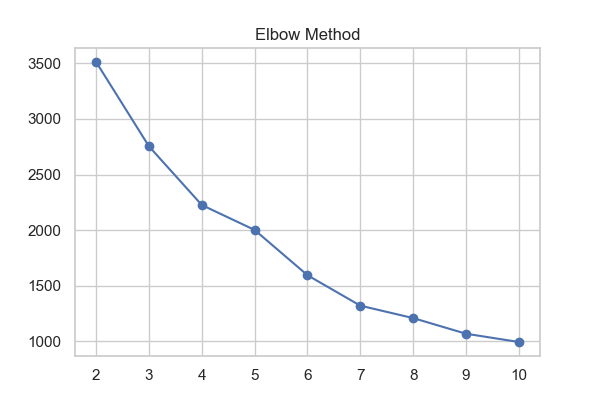

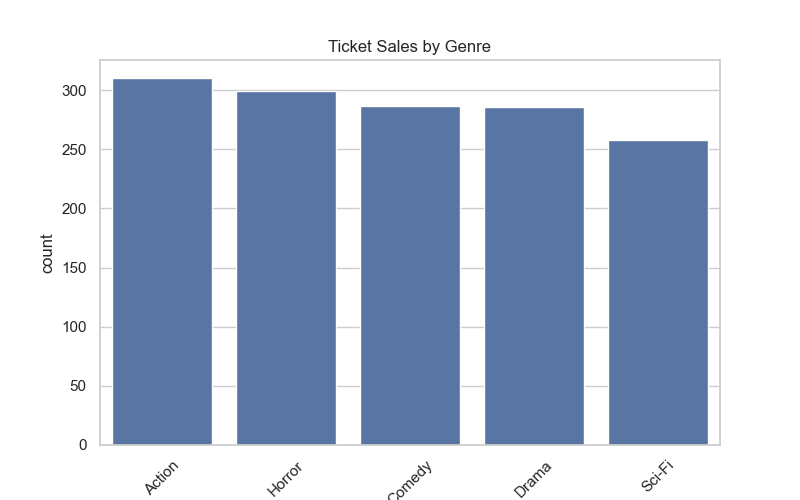

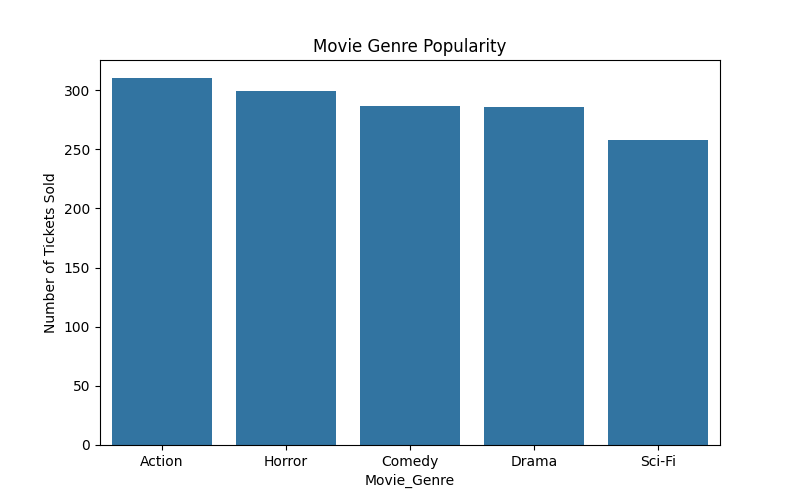

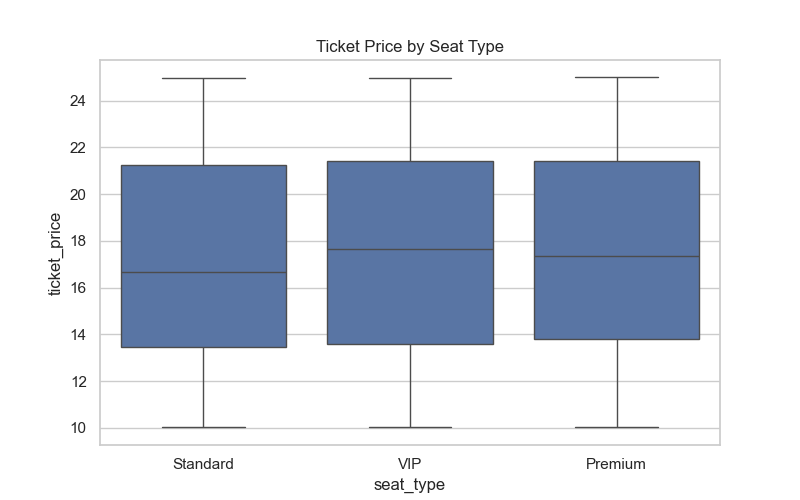

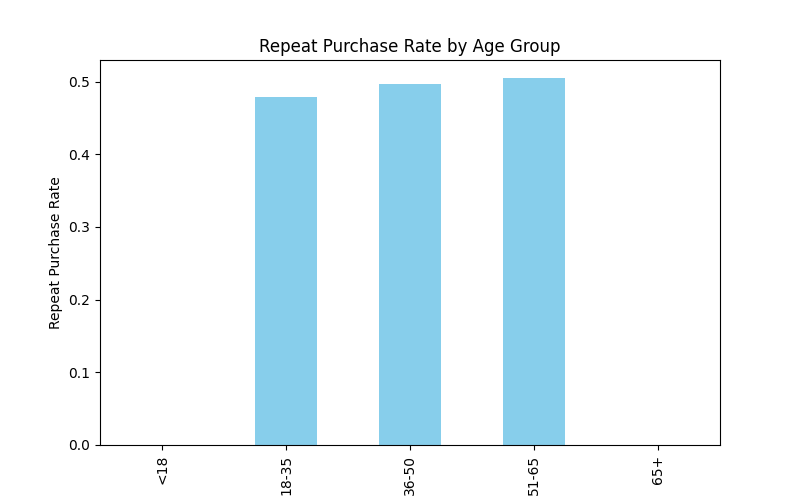

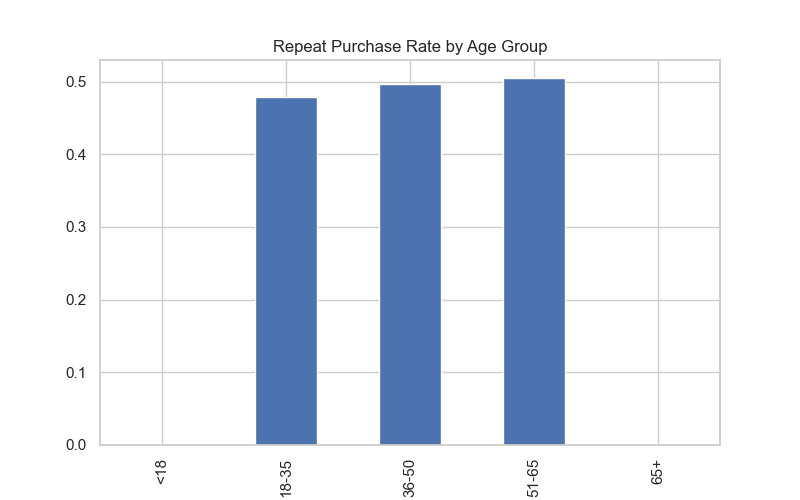

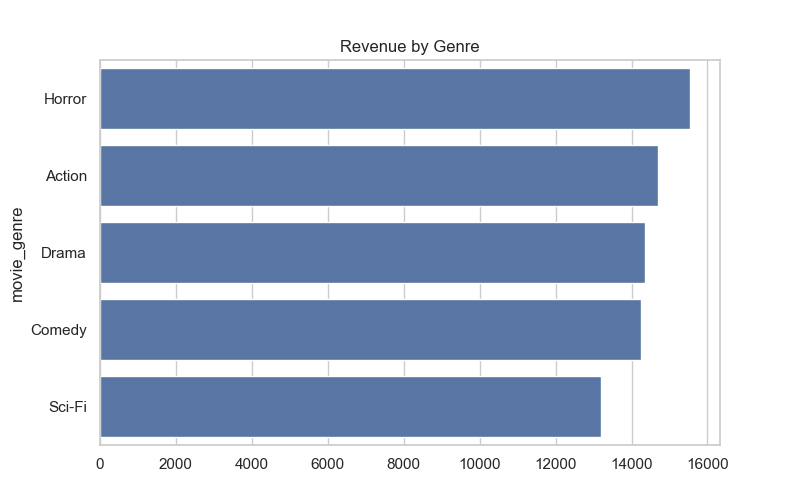

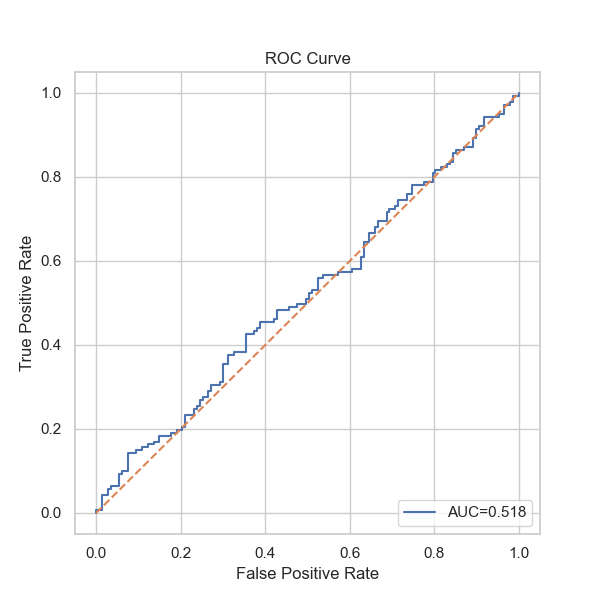

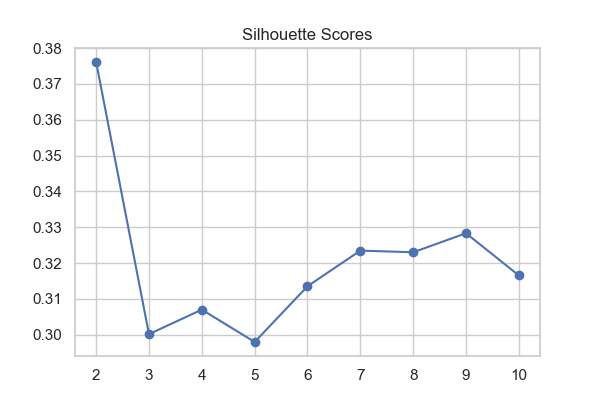

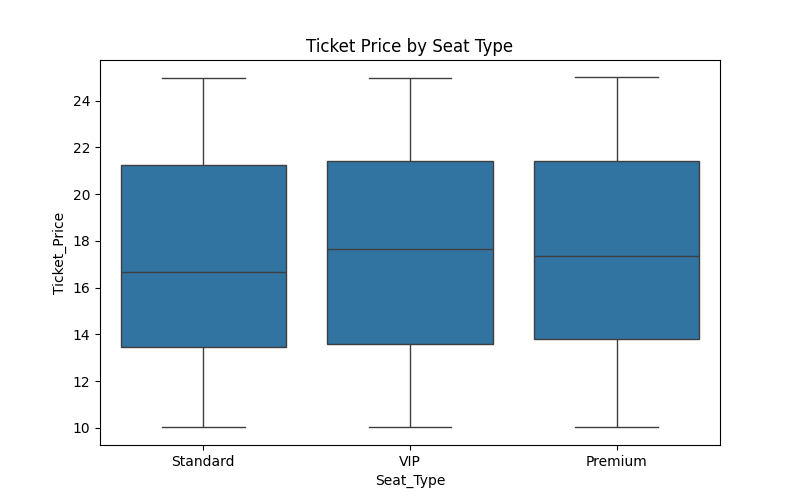

In [11]:
# Display first 20 visuals
from IPython.display import Image, display
imgs = sorted(f for f in os.listdir(ARTIFACT_DIR) if f.endswith('.png'))
for f in imgs[:20]:
    display(Image(os.path.join(ARTIFACT_DIR, f)))


In [12]:
# Show best saved model pipeline
best = joblib.load(BEST_PATH)
print(best)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'number_of_person',
                                                   'ticket_price', 'revenue',
                                                   'price_per_person',
                                                   'is_weekend']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['seat_type', 'movie_genre',
                                                   'age_group'])])),
                ('clf', GaussianNB())])


In [13]:
# Show scalers
num_scaler = joblib.load(SCALER_PATH)
cluster_scaler = joblib.load(CLUSTER_SCALER_PATH)
from pprint import pprint
print("Numeric scaler:")
pprint({'mean_': num_scaler.mean_.tolist(), 'scale_': num_scaler.scale_.tolist()})
print("\nCluster scaler:")
pprint({'mean_': cluster_scaler.mean_.tolist(), 'scale_': cluster_scaler.scale_.tolist()})


Numeric scaler:
{'mean_': [38.786458333333336,
           2.8958333333333335,
           17.319791666666667,
           50.19030381944444,
           10.636256882440476,
           0.0],
 'scale_': [12.527451410621639,
            2.193642170505988,
            4.370438430484152,
            41.57304684262655,
            7.376688509488864,
            1.0]}

Cluster scaler:
{'mean_': [38.90486111111111,
           17.38397222222222,
           2.8819444444444446,
           50.05024999999999],
 'scale_': [12.421977778323157,
            4.39555993453818,
            2.19182992984356,
            41.45068844514393]}
